# Pruning_the_Greens

> *At a nursery* <br>
> Thats a moneyplant init? Actually sir those are weeds.

<a id = 'begin'></a>
# [Before the Beginning](#toc)

>In the beginning God created the heavens and the earth. Now the earth was formless and empty, darkness was over the surface of the deep, and the Spirit of God was hovering over the waters. And God said, “Let there be light,” and there was light.

<a id = 'intro'></a>
## [1. Introduction](#toc)

In this notebook we'll be using some well-known architectures to learn to recognise the species of plant from the image of its sapling. This seems pretty legit doesn't it? We've moved to classifying things even humans have difficulties in recognising. 

<a id = 'import'></a>
## [2. Importing the Essential Libraries](#toc)

> Sumerians invented the wheel. I'd much rather just use it. 

In [1]:
import numpy as np
import itertools
import os
import PIL
import pathlib
import math
import random
import seaborn as sns
import tensorflow as tf
from tensorflow.python.saved_model import tag_constants
from sklearn.metrics import classification_report, confusion_matrix
from IPython.display import HTML, display
import tabulate
from tensorflow import keras
import matplotlib.pyplot as plt
from tqdm import tqdm
import tempfile
from time import time

%matplotlib inline

!/usr/local/cuda/bin/nvcc --version

!nvidia-smi 

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
Tue Nov  9 07:47:09 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |            

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<a id = 'load'></a>
## [3. Examining the Data](#toc)

> Getting a piece of the pie? Here's some more.


After running the script in the folder, we have balanced the data


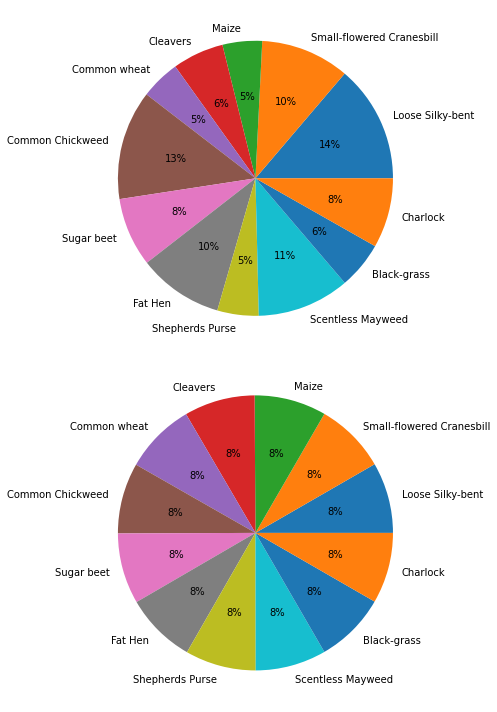

In [3]:
training_images = '/content/drive/MyDrive/Assignments/Week 8/Data/train'
categories = [category for category in os.listdir(training_images)]
distribution_old = [len(os.listdir(os.path.join(training_images, category))) for category in categories]


training_images_updated = '/content/drive/MyDrive/Assignments/Week 8/Data/train_updated'
distribution_new = [len(os.listdir(os.path.join(training_images_updated, category))) for category in categories]

plt.figure(figsize=(20, 10));
plt.subplot(2,1,1);
plt.pie(distribution_old, labels = categories, autopct='%.0f%%')

print('After running the script in the folder, we have balanced the data')

plt.subplot(2,1,2);
plt.pie(distribution_new, labels = categories, autopct='%.0f%%')
plt.tight_layout()

So we can see that the dataset is more or less balanced. This has been achieved only after augmentation by another script.

<a id = 'normalise'></a>
## [Load Data](#toc)

Before augmentation, we need to convert all images to a uniform size and also normalise the images by rescaling to a value between 0 and 1.

In [4]:
def prepare_data(cnn_model = 'inception', IMG_SHAPE = (400,400)):
  """
  """
  from keras_preprocessing.image import ImageDataGenerator
  from tensorflow.keras.applications import inception_v3
  from tensorflow.keras.applications import resnet50
  from tensorflow.keras.applications import vgg16

  if cnn_model == 'inception':
    datagen = ImageDataGenerator(preprocessing_function = inception_v3.preprocess_input,
                                 horizontal_flip = True,
                                 height_shift_range = 0.1,
                                 width_shift_range = 0.1,
                                 rotation_range = 10,
                                 zoom_range = 0.1,
                                 validation_split = 0.2)
  elif cnn_model == 'resnet':
    datagen = ImageDataGenerator(preprocessing_function = resnet50.preprocess_input,
                                 horizontal_flip = True,
                                 height_shift_range = 0.1,
                                 width_shift_range = 0.1,
                                 rotation_range = 10,
                                 zoom_range = 0.1,
                                 validation_split = 0.2)
  elif cnn_model == 'vgg16':
    datagen = ImageDataGenerator(preprocessing_function = vgg16.preprocess_input,
                                 horizontal_flip = True,
                                 height_shift_range = 0.1,
                                 width_shift_range = 0.1,
                                 rotation_range = 10,
                                 zoom_range = 0.1,
                                 validation_split = 0.2)
    
  train_ds = datagen.flow_from_directory(directory = '/content/drive/MyDrive/Assignments/Week 8/Data/train',
                                         target_size = IMG_SHAPE,
                                         subset = 'training',
                                         batch_size = 32,
                                         class_mode = 'categorical',
                                         shuffle = True,
                                         seed = 123)
  val_ds = datagen.flow_from_directory(directory = '/content/drive/MyDrive/Assignments/Week 8/Data/train_updated',
                                       target_size = IMG_SHAPE,
                                        subset = 'validation',
                                        batch_size = 32,
                                        class_mode = 'categorical',
                                        shuffle = False,
                                        seed = 123)
  return train_ds, val_ds

In [5]:
train_ds, val_ds = prepare_data(cnn_model = 'vgg16')

Found 3803 images belonging to 12 classes.
Found 1562 images belonging to 12 classes.


In [6]:
def get_confusion_matrix(y_true, y_pred):
  """
  """
  from sklearn.metrics import confusion_matrix
  import seaborn as sns
  conf_matrix = confusion_matrix(y_true, y_pred)
  plt.figure(figsize=(20, 5))
  sns.heatmap(conf_matrix, annot=True, cmap='Blues')
  plt.show()

In [7]:
vgg16_model = tf.keras.models.load_model('/content/drive/MyDrive/Assignments/Week 8/Saved_Model/my_model')
vgg16_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, None, None, None)  0         
_________________________________________________________________
vgg16 (Functional)           (None, None, None, 512)   14714688  
_________________________________________________________________
sequential (Sequential)      (None, 12)                9439372   
Total params: 24,154,060
Trainable params: 18,878,348
Non-trainable params: 5,275,712
_________________________________________________________________


In [8]:
predictions = vgg16_model.predict(val_ds, verbose=1, workers=2,)
y_pred_bool = np.argmax(predictions, axis = 1)

49/49 [==============================] - 473s 9s/step


In [9]:
predictions.shape

(1562, 12)

In [10]:
from sklearn.metrics import classification_report
print(classification_report(val_ds.classes, y_pred_bool))

              precision    recall  f1-score   support

           0       0.77      0.57      0.65       130
           1       0.98      0.96      0.97       130
           2       0.93      0.98      0.95       130
           3       0.95      0.95      0.95       130
           4       0.97      0.88      0.93       130
           5       0.88      0.92      0.90       130
           6       0.66      0.89      0.76       130
           7       0.98      0.97      0.98       132
           8       0.78      0.92      0.85       130
           9       0.93      0.81      0.86       130
          10       0.96      0.97      0.97       130
          11       0.98      0.88      0.93       130

    accuracy                           0.89      1562
   macro avg       0.90      0.89      0.89      1562
weighted avg       0.90      0.89      0.89      1562



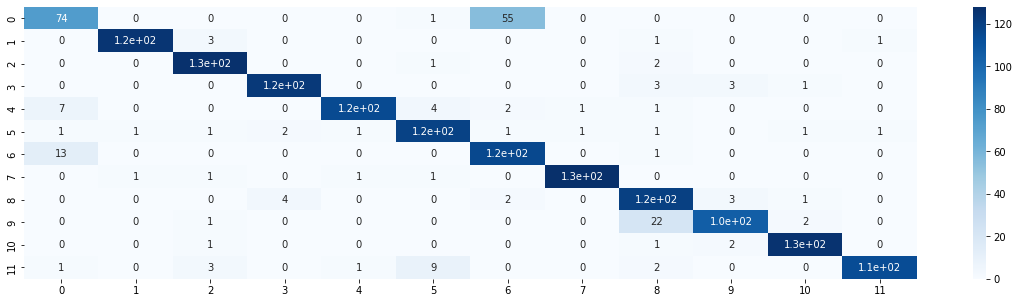

In [11]:
get_confusion_matrix(val_ds.classes, y_pred_bool)

In [8]:
from tensorflow.python.compiler.tensorrt import trt_convert as trt
SAVED_MODEL = '/content/drive/MyDrive/Assignments/Week 8/Saved_Model/my_model'

### TF-TRT FP32 Model

In [9]:
OUTPUT_DIR = '/content/drive/MyDrive/Assignments/Week 8/Output_Dir'

In [ ]:
conversion_params = trt.DEFAULT_TRT_CONVERSION_PARAMS._replace(precision_mode = trt.TrtPrecisionMode.FP32,
                                                               max_workspace_size_bytes = 8000000000)
converter = trt.TrtGraphConverterV2(input_saved_model_dir = SAVED_MODEL, conversion_params = conversion_params)
converter.convert()

converter.save(output_saved_model_dir = '/content/drive/MyDrive/Assignments/Week 8/Output_Dir/TRT_FP32')

INFO:tensorflow:Linked TensorRT version: (0, 0, 0)
INFO:tensorflow:Loaded TensorRT version: (0, 0, 0)
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Assignments/Week 8/Output_Dir/TRT_FP32/assets


In [ ]:
FP_32_SAVE_DIRECTORY = os.path.join(OUTPUT_DIR, 'TRT_FP32')

def benchmark_saved_model(val_ds, SAVED_MODEL_DIR, BATCH_SIZE = 32):
  saved_model_loaded = tf.saved_model.load(SAVED_MODEL_DIR, tags = [tag_constants.SERVING])
  signature_keys = list(saved_model_loaded.signatures.keys())
  infer = saved_model_loaded.signatures['serving_default']
  num_hits = 0
  num_predict = 0
  t0 = time()
  num_of_checks = 0
  for x, y in tqdm(val_ds):
    if num_of_checks>=16:
      break
    x = tf.convert_to_tensor(x)
    labeling = infer(x)
    preds = labeling['sequential'].numpy()
    preds_classes = np.argmax(preds, axis = 1)
    y_classes = np.argmax(y, axis = 1)
    num_hits +=np.sum(preds_classes == y_classes)
    num_predict += preds.shape[0]
    num_of_checks += 1

  print('Accuracy: %.2f%%'%(100*num_hits/num_predict))
  print('Inference speed: %.2f samples/s'%(num_predict/(time()-t0)))

In [ ]:
benchmark_saved_model(val_ds, FP_32_SAVE_DIRECTORY, 32)

 33%|███▎      | 16/49 [00:41<01:24,  2.57s/it]

Accuracy: 83.99%
Inference speed: 12.28 samples/s


### TF-TRT FP 16 Model

In [ ]:
conversion_params = trt.DEFAULT_TRT_CONVERSION_PARAMS._replace(precision_mode = trt.TrtPrecisionMode.FP16,
                                                               max_workspace_size_bytes = 8000000000)
converter = trt.TrtGraphConverterV2(input_saved_model_dir = SAVED_MODEL, conversion_params = conversion_params)
converter.convert()

converter.save(output_saved_model_dir = '/content/drive/MyDrive/Assignments/Week 8/Output_Dir/TRT_FP16')

INFO:tensorflow:Linked TensorRT version: (0, 0, 0)
INFO:tensorflow:Loaded TensorRT version: (0, 0, 0)
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Assignments/Week 8/Output_Dir/TRT_FP16/assets


In [ ]:
FP_16_SAVE_DIRECTORY = os.path.join(OUTPUT_DIR, 'TRT_FP16')
benchmark_saved_model(val_ds, FP_16_SAVE_DIRECTORY, 32)

 33%|███▎      | 16/49 [00:37<01:17,  2.36s/it]

Accuracy: 85.74%
Inference speed: 13.55 samples/s


Turns out the 16 bit quantised model works better - both in terms of accuracy as well as speed of predictions! Now thats a first. 

### TF-TRT INT8 Model

In [ ]:
num_calibration_batches = 2
data = []
labels = []
for i, (x, y) in enumerate(val_ds):
  data.append(x)
  labels.append(y)
  if i>=1:
    break

print(np.asarray(data).shape, np.asarray(labels).shape)

calibration_dataset = tf.data.Dataset.from_tensor_slices((np.asarray(data), np.asarray(labels)))
def calibration_input_function():
  for x, y in calibration_dataset:
    yield(x, )

(2, 32, 400, 400, 3) (2, 32, 12)


In [ ]:
INT_8_SAVE_DIRECTORY = os.path.join(OUTPUT_DIR, 'TRT_INT8')
conversion_params = trt.DEFAULT_TRT_CONVERSION_PARAMS._replace(precision_mode = trt.TrtPrecisionMode.INT8,
                                                               max_workspace_size_bytes = 8000000000)
converter = trt.TrtGraphConverterV2(input_saved_model_dir = SAVED_MODEL, conversion_params = conversion_params)
converter.convert(calibration_input_fn=calibration_input_function)

converter.save(output_saved_model_dir = INT_8_SAVE_DIRECTORY)

INFO:tensorflow:Linked TensorRT version: (0, 0, 0)
INFO:tensorflow:Loaded TensorRT version: (0, 0, 0)
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Assignments/Week 8/Output_Dir/TRT_INT8/assets


In [ ]:
benchmark_saved_model(val_ds, INT_8_SAVE_DIRECTORY, 32)

 33%|███▎      | 16/49 [00:35<01:13,  2.23s/it]

Accuracy: 93.75%
Inference speed: 14.34 samples/s


Whoa!! Thats some next level stuff. I actually expected the accuracy to be adversely impacted with quantisation but the results are contrary to what I had thought. Great job Google!

## Model Optimization Using Tensorflow

In [10]:
_, keras_file = tempfile.mkstemp('.h5')
tf.keras.models.save_model(vgg16_model, keras_file, include_optimizer=False)

In [11]:
converter = tf.lite.TFLiteConverter.from_saved_model(SAVED_MODEL)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()
_, tflite_file = tempfile.mkstemp('.tflite')
with open(tflite_file, 'wb') as f:
  f.write(tflite_model)

In [12]:
def gzipped_model_size(file):
  import os
  import zipfile
  _, zipped_file = tempfile.mkstemp('.zip')
  with zipfile.ZipFile(zipped_file, 'w', compression = zipfile.ZIP_DEFLATED) as f:
    f.write(file)
  return os.path.getsize(zipped_file)

print(f'Size of Gzipped Base Keras Model is {gzipped_model_size(keras_file)}')
print(f'Size of Gzipped TFLite Model is {gzipped_model_size(tflite_file)}')

Size of Gzipped Base Keras Model is 89905582
Size of Gzipped TFLite Model is 18173448


In [13]:
tflite_path = '/content/drive/MyDrive/Assignments/Week 8/Output_Dir/quantised_model.tflite'
with open(tflite_path, 'wb') as f:
  f.write(tflite_model)

In [14]:
input_data = []
input_labels = []
for i, (x, y) in tqdm(enumerate(val_ds)):
  if i>=len(val_ds):
    break
  input_data.append(x)
  input_labels.append(y)

input_data = np.concatenate(input_data, axis = 0)
input_labels = np.concatenate(input_labels, axis = 0)

# output = my_signature(val_ds)
# print(output['result'])

49it [01:07,  1.38s/it]


In [15]:
input_data.shape, input_labels.shape

((1562, 400, 400, 3), (1562, 12))

In [17]:
interpreter = tf.lite.Interpreter(model_path = tflite_path)
input_details = interpreter.get_input_details()
interpreter.allocate_tensors()
output_details = interpreter.get_output_details()
input_shape = input_details[0]['shape']
num_hits = 0
num_predict = 0
t0 = time()

for i in tqdm(range(3)):
  interpreter.set_tensor(input_details[0]['index'], np.expand_dims(input_data[i], axis = 0))
  interpreter.invoke()
  output_data = interpreter.get_tensor(output_details[0]['index'])
  preds_classes = np.argmax(output_data)
  y_classes = np.argmax(input_labels[i])
  num_hits += np.sum(preds_classes == y_classes)
  num_predict += 1

print('Accuracy: %.2f%%'%(100*num_hits/num_predict))
print('Inference speed: %.2f s'%(time()-t0))

100%|██████████| 3/3 [07:33<00:00, 151.33s/it]

Accuracy: 100.00%
Inference speed: 454.00 s
